## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
# df.nunique()
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [8]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [9]:
df.query('(landing_page=="new_page" and group!="treatment") or (landing_page!="new_page" and group=="treatment")').shape

(3893, 5)

In [10]:
df.groupby(['landing_page'])['group'].value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [11]:
1928 + 1965

3893

f. Do any of the rows have missing values?

In [12]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [6]:
# drop the necessary rows
df2 = df.drop(df.query('(landing_page=="new_page" and group!="treatment") or (landing_page!="new_page" and group=="treatment")').index)

In [7]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [17]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
# keep first, remove second duplicate i.e. remove 2893
df2 = df2[~df2['user_id'].duplicated(keep='first')]

In [19]:
# confirm duplicates
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
ctrl_conv = df2.query('group == "control"')['converted'].mean()
ctrl_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
treatment_conv = df2.query('group == "treatment"')['converted'].mean()
treatment_conv

0.11880806551510564

In [23]:
obs_diff = treatment_conv - ctrl_conv
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [24]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

As evident from the difference (-0.0015), there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the treatment group is less than that for the control group.

---
<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Our alternative hypothesis is what we want to prove to be true, in this case, that the new page is better than the old page. And, the null hypothesis is what we assume to be true before analyzing data, which is that the new page has conversion rate that is less than or equal to that of the old page.

$$H_0: p_{new} \leq p_{old}$$
$$H_1: p_{new} \gt p_{old}$$
i.e.
$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} \gt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [27]:
diff = p_new-p_old
diff

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [33]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.11818181818181818

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [34]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.12051020829604747

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [35]:
diff_page_converted = new_page_converted.mean() - old_page_converted.mean()
diff_page_converted

-0.0023283901142292923

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [17]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs[:5]

[-0.00082815948210174239,
 0.0018630249134361093,
 -0.0019221996130857899,
 -0.0014680408847792814,
 -0.0017776434795298973]

In [24]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

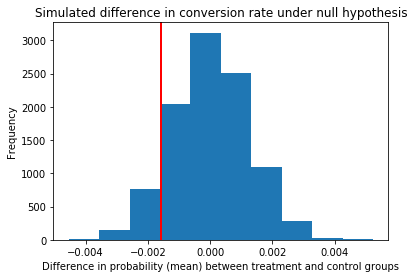

In [27]:
plt.hist(p_diffs)
plt.title('Simulated difference in conversion rate under null hypothesis')
plt.xlabel('Difference in probability (mean) between treatment and control groups')
plt.ylabel('Frequency')
plt.axvline(x=obs_diff, color='red', linewidth=2, label='mean of absolute data difference');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [23]:
(p_diffs > obs_diff).mean()

0.90329999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

The proportion of the `p_diffs` that are greater than the actual difference observed in `ab_data.csv` is called **p-value**. 

> The p-value is  the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. A small p-values suggest our null is not true. When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null. By comparing our p-value to our type I error threshold ($\alpha$), we can make our decision about which hypothesis we will choose.
$$\text{p-value} \leq \alpha \Rightarrow \text{Reject } H_0$$
$$\text{p-value} > \alpha \Rightarrow \text{Fail to Reject } H_0$$

Since, here, our p-value (0.90) is far greater than $\alpha$ (0.05), we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
# one-sided z-test
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

The p-value calculated (0.905) is approx. same compared to calculated earlier (0.903) in bootstrapped hypothesis testing.

Considering the significance level of 95%, the z-score less than -1.96 or greater than 1.96 will be significant. Since, the conversion rate of the new landing page is only 1.3109 standard deviations away from the conversion rate of the old landing page, we cannot reject the hull hypothesis.

The same analysis goes for the p-value as our p-value (0.90) is far greater than $\alpha$ (0.05), we fail to reject the null hypothesis.

---
<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

We are going to use Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [37]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [7]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [10]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 10:54 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

The p-value associated with `ab_page` is 0.1899. It's smaller than the one calculated earlier (0.90). The difference is due to the fact that in part II, we performed a one-sided test, whereas in the logistic regression part, it is two-sided test. 

The null hypothesis in our logistic regression model argues that there is no relationship among the dependent and independent variables. In this case, we would state that the conversion is not related to the page that was shown (new page) to the user. The alternative would suggest that there is a relation between the page showed (new page) to the user and the conversion. So that the new page would lead to higher conversions.

$$H_0: p_{new} = p_{old}$$
$$H_1: p_{new} \neq p_{old}$$
i.e.
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

It's a good idea to add other factors to our model as they might affect the conversion. There is a disadvantage in case the other variables are correlated with the present variables in the model, then our results may alter or wrong. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [8]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [10]:
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,US,UK,CA
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,0,0,1


In [12]:
# fit model
df_new['intercept'] = 1
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 11:10 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

Since the p-values are greater than 0.05, we fail to reject the null hypothesis, and hence, country has an impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [16]:
df_new['new_CA'] = df_new['CA']*df_new['ab_page']
df_new['new_US'] = df_new['US']*df_new['ab_page']
df_new['new_UK'] = df_new['UK']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,new_CA,new_US,new_UK
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0,1


In [17]:
lm = sm.OLS(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'new_UK', 'new_US']])
results3 = lm.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Mon, 20 Apr 2020   Prob (F-statistic):              0.197
Time:                        11:15:32   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
UK             0.0012      0.004      0.296      0.767      -0.007       0.009
US             0.0018      0.004      0.467      0.641      -0.006       0.010
new_UK         0.0080      0.006      1.360      0.174      -0.004       0.020
new_US         0.0047      0.006      0.845      0.398      -0.006       0.016
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, the p-values are greater than 0.05, we fail to reject the null hypothesis, and hence conclude that the combined page and country also has no impact on conversion.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [11]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0